In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
import seaborn as sns
import shapely
import shapely.ops
import shapely.geometry
from sklearn.cluster import KMeans
from skimage.segmentation import flood_fill, flood
from skimage import filters, measure
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return list(zip(a, b))

sns.set()

In [2]:
viet_mesh = pv.read('./viet/V2_2_105.75_15.98_tile_1_1.stl')
viet_plane = viet_mesh.project_points_to_plane().points
viet_edge = viet_mesh.project_points_to_plane().extract_feature_edges().points
viet_bounds = viet_mesh.bounds

n_pieces = 16

In [3]:
kmeans = KMeans(n_clusters=n_pieces, random_state=0).fit(viet_plane[:,:2])
clusters = kmeans.predict(viet_plane[:,:2])
vor = Voronoi(kmeans.cluster_centers_, qhull_options='Qbb Qc Qx')

region_bbox = shapely.geometry.Polygon(zip(
    [viet_plane[:,0].min()-5, viet_plane[:,0].min()-5, viet_plane[:,0].max()+5, viet_plane[:,0].max()+5, viet_plane[:,0].min()-5], 
    [viet_plane[:,1].min()-5, viet_plane[:,1].max()+5, viet_plane[:,1].max()+5, viet_plane[:,1].min()-5, viet_plane[:,1].min()-5]
))

In [4]:
viet_plane_df = pd.DataFrame(viet_plane, columns=['x','y','z'])
viet_plane_df['cluster'] = clusters

pieces = []
for g, gdf in viet_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)

In [5]:
connected_pieces = []
for idx, p0 in enumerate(pieces):
    for jdx, p1 in enumerate(pieces[idx+1:], idx+1):
        if idx == jdx: continue
        line = shapely.geometry.LineString([p0.centroid, p1.centroid])
        poly_intersections = [(i, line.intersection(p).length) for i, p in enumerate(pieces) if line.intersects(p)]
        if len(poly_intersections) == 2:
            if (poly_intersections[0][1] + poly_intersections[1][1]) / line.length > 0.9:
                connected_pieces.append([(i,pieces[i].centroid.coords[0]) for i, length in poly_intersections])
        
for (i, c0),(j,c1) in connected_pieces:
    line = shapely.geometry.LineString([c0, c1])
    near_center_point = line.interpolate(0.65, normalized=True)
    near_center_point_poly = shapely.geometry.LineString([line.coords[0], near_center_point]).buffer(0.5)
    near_center_point_buffer = near_center_point.buffer(1.5)
    x, y = near_center_point_buffer.exterior.xy
    
    x.append(x[0])
    y.append(y[0])
    near_center_point_buffer = shapely.geometry.Polygon(zip(x[::3],y[::3]))
    near_center_point_poly = shapely.ops.cascaded_union([near_center_point_poly, near_center_point_buffer])
    
    pieces[i] = shapely.ops.cascaded_union([pieces[i], near_center_point_poly]).buffer(-0.01)
    pieces[j] = pieces[j].difference(near_center_point_poly.buffer(0.01))

No handles with labels found to put in legend.


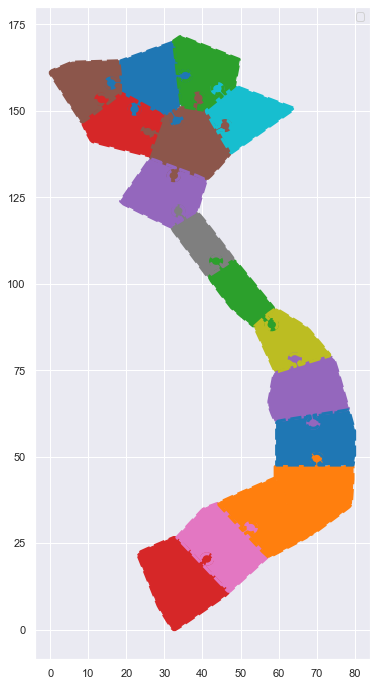

In [6]:
fig, ax = plt.subplots(1, figsize=(6,12))
# ax.scatter(viet_plane[:,0], viet_plane[:,1], c=clusters, alpha=1, s=10)
# ax.scatter(viet_edge[:,0], viet_edge[:,1], alpha=0.4)
c = plt.cm.tab10.colors
for idx, p in enumerate(pieces):
    x, y = p.exterior.xy
    plt.plot(x,y,lw=3,ls='--', c=c[idx%len(c)])
    plt.fill(x,y, c=c[idx%len(c)])
plt.legend()
plt.show()

In [7]:
pieces_3d = []

for idx, p in enumerate(pieces):
    x, y = p.buffer(-0.05).boundary.xy
    x.append(x[0])
    y.append(y[0])
    
#     mesh_verts_faces = [tc.triangulate_polygon(p) for p in pieces]
#     mesh_verts = []
#     mesh_faces = []
#     for idx, (v, f) in enumerate(mesh_verts_faces):
#         v0 = np.zeros((v.shape[0],3))
#         v0[:,:2] = v
#         v0[:,2] = viet_bounds[4]
#         mesh_verts.append(v0)
#         mesh_faces.append(f)

#     trimeshes = [pv.wrap(
#         trimesh.Trimesh(
#             vertices=v, faces=f, process=False
#         )
#     ) for v, f in zip(mesh_verts, mesh_faces)]

    
    
    
    z_low = np.full(len(x), viet_bounds[4]-1)
    z_high = np.full(len(x), viet_bounds[5]+1)
    piece_3d = np.zeros(shape=(2*len(x), 3))
    piece_3d[:,0], piece_3d[:,1] = np.hstack([x,x]), np.hstack([y,y])
    piece_3d[:,2] = np.hstack([z_low, z_high])
    
    piece_3d_lines = [[2,i,i+1] for i in range(len(x)-1)]
    piece_3d_lines.extend([[2,len(x)+i,len(x)+i+1] for i in range(len(x)-1)])
    piece_3d_lines.extend([[2,i,i+len(x)] for i in range(len(x))])

    top_face = [len(x)]
    top_face.extend(list(range(len(x))))
    bot_face = [len(x)]
    bot_face.extend(list(range(len(x), 2*len(x))))

    side_faces = [[4,idx,idx+1,idx+len(x)+1,idx+len(x)] for idx in range(len(x)-1)]
    side_faces.append([4,0,len(x)-1,2*len(x)-1,len(x)])
    side_faces = np.vstack(side_faces)

    faces = np.hstack([top_face, bot_face])
    faces = np.append(faces, side_faces)

    piece_3d = pv.PolyData(piece_3d, faces)
    piece_3d['my labels'] = [f"idx:{i}" for i in range(piece_3d.n_points)]


    piece_3d.lines = piece_3d_lines
    piece_3d = piece_3d.clip_surface(piece_3d)

    pieces_3d.append(piece_3d)

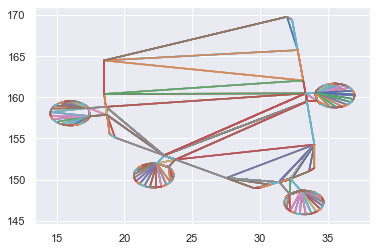

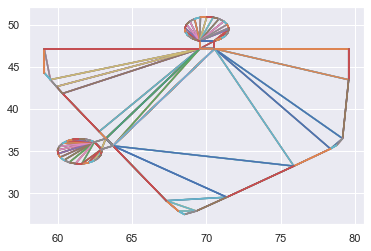

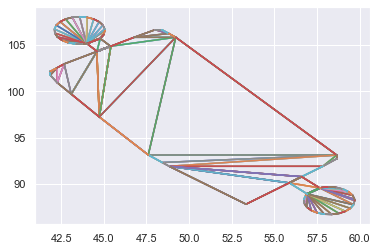

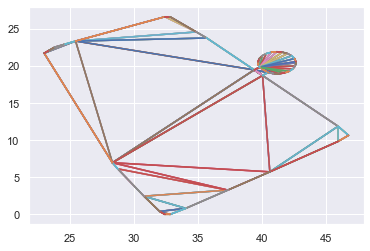

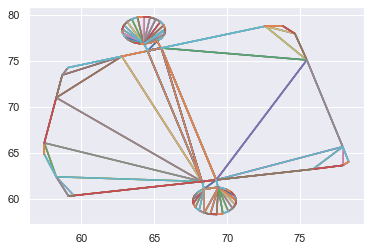

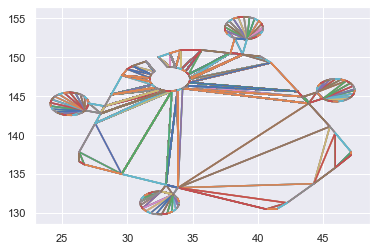

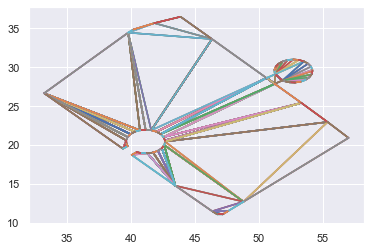

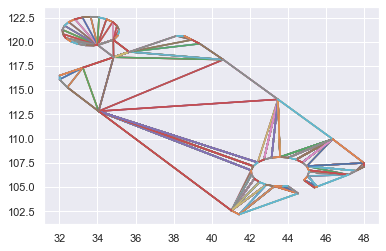

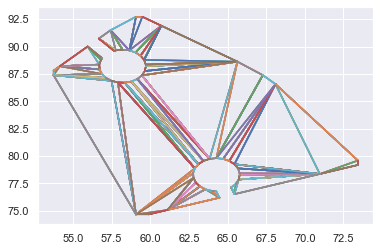

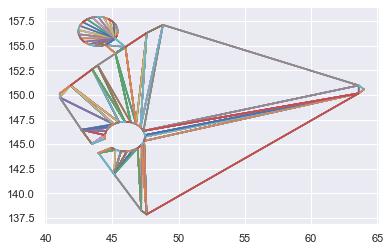

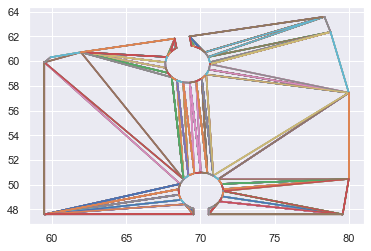

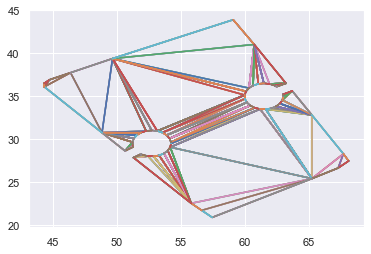

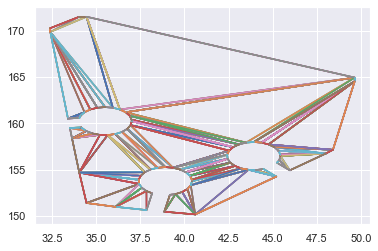

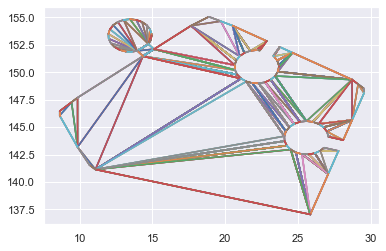

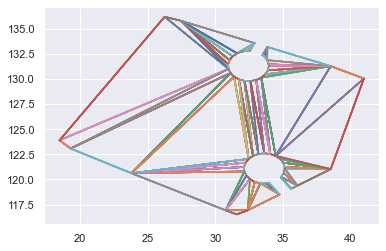

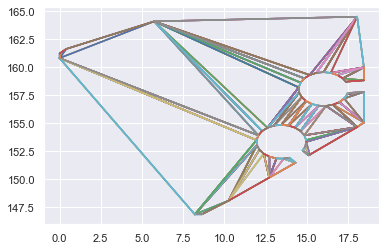

In [8]:
import trimesh.path.polygons as tpp
import trimesh.creation as tc

mesh_pieces = []
for idx, p in enumerate(pieces):
    mesh_piece = []
    for t in tc.extrude_polygon(p, 1).triangles:
        t = np.vstack([t, [t[0]]])
        mesh_piece.append(t)
        plt.plot(t[:,0], t[:,1])
    mesh_pieces.append(mesh_piece)
    plt.show()
    
    if idx == 5:
        pp = p
# mesh_pieces = [tc.extrude_polygon(p, 1).triangles for p in pieces]

In [9]:
faces = []
for fa in tc.extrude_polygon(pp, 1).faces:
    faces.append([3] + fa.tolist())

In [249]:
import trimesh

m = tc.extrude_polygon(pp, 1)
print(m.is_watertight)

p = pv.Plotter(
    notebook=False
)
m = pv.wrap(
    m.apply_transform(
        trimesh.transformations.scale_and_translate(scale=[1,1,viet_bounds[5]+2], translate=[0,0,-1])
    )
)
p.add_mesh(m, opacity=0.5, show_edges=True, color='r')
p.show_grid()
p.add_mesh(viet_mesh, opacity=0.1, show_edges=True, color='tan')
p.show()

True


[(68.82021752923049, -10.478714973784246, 360.15555159645004),
 (40.0, 85.74359130859375, 7.227816104888916),
 (-0.7044076873777975, -0.6973016734158926, -0.13259029457113133)]

In [250]:
type(m)

pyvista.core.pointset.PolyData

In [263]:
vmc = viet_mesh.clip_surface(m)

vox = pv.voxelize(m, density=m.length/200)

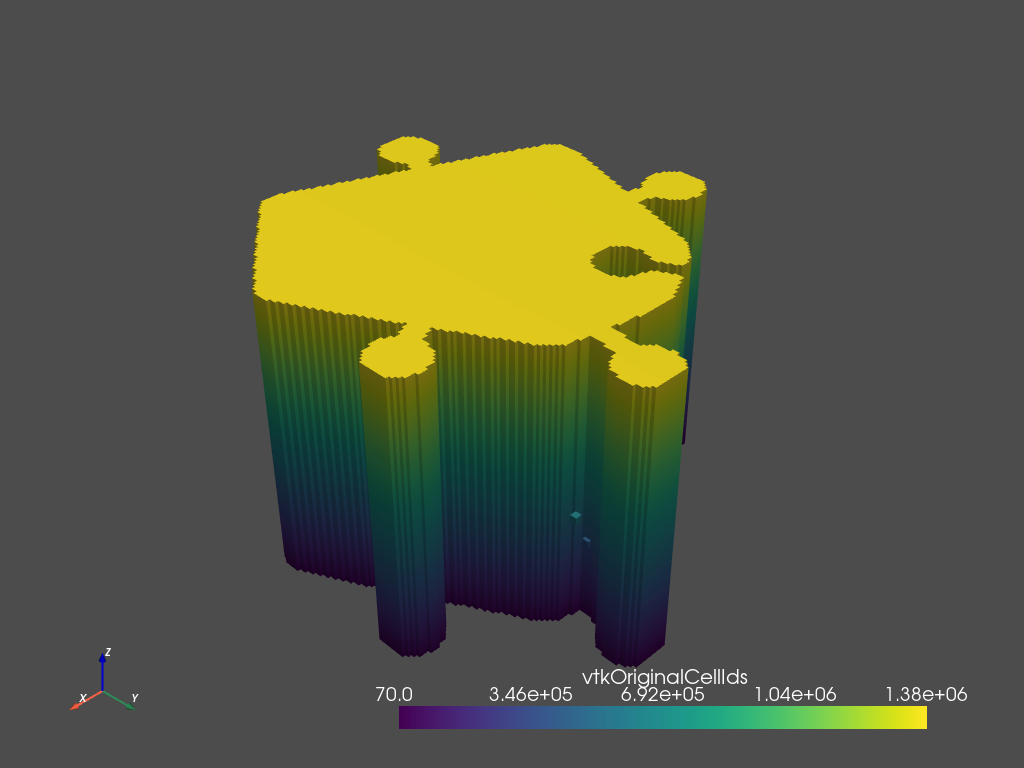

[(78.19559168842619, 184.87863672184713, 49.66316840735338),
 (35.74567321058271, 142.42871824400365, 7.213249929509903),
 (0.0, 0.0, 1.0)]

In [265]:
vox.plot(notebook=True)

In [268]:
vox_m = vox.clip_surface(viet_mesh)

In [274]:
mesh = vox_m.extract_surface().elevation()

mesh.plot(style='wireframe', notebook=False)

[(48.1079510089901, 127.86330310327284, 69.43633484776505),
 (35.74567321058271, 142.42871824400365, 4.036172136888963),
 (-0.9742984648015103, -0.17158086076976037, 0.1459537930405671)]

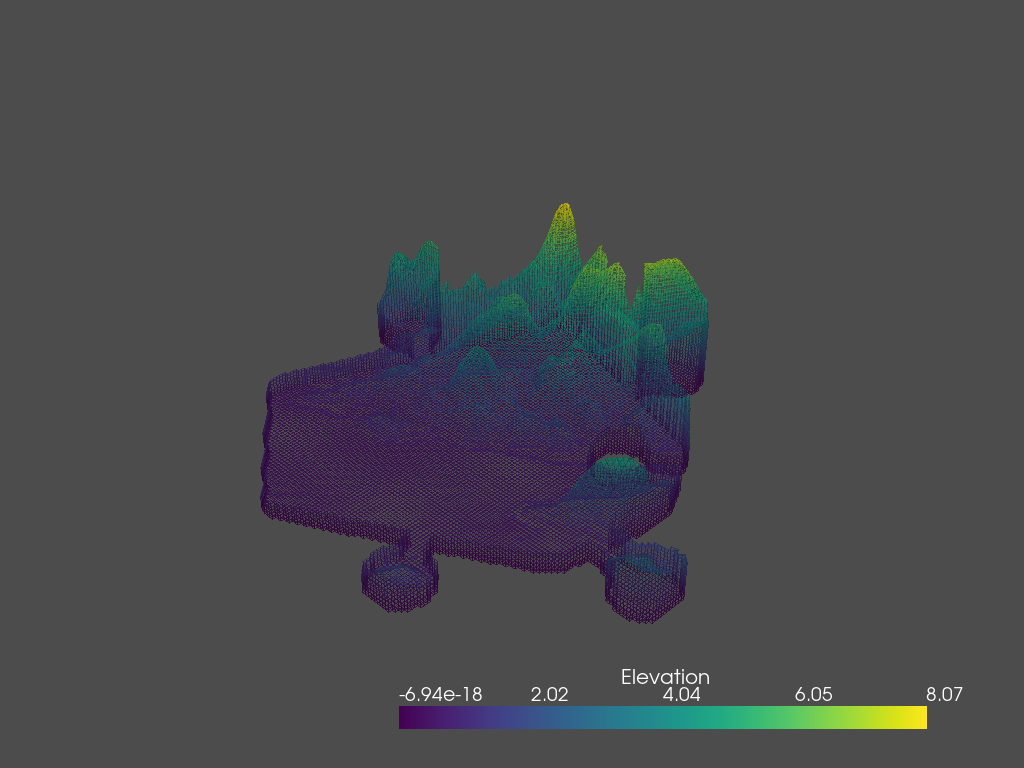

In [280]:
p = pv.Plotter()
p.add_mesh(mesh, style='wireframe', opacity=0.5)
p.show(auto_close=False)
path = p.generate_orbital_path(n_points=36, shift=mesh.length)
p.open_gif("orbit.gif")
p.orbit_on_path(path, write_frames=True)
p.close()

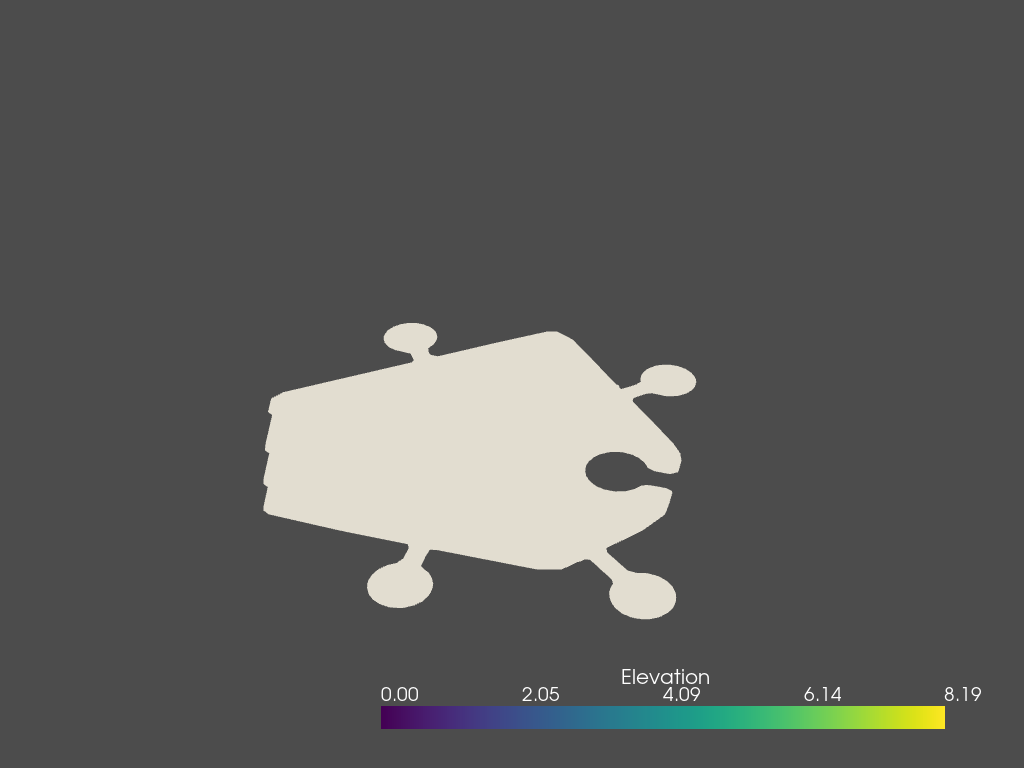

[(75.23569159799499, 182.0065198450653, 43.58079724603576),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (0.0, 0.0, 1.0)]

In [262]:
origin = vmc.center
origin[-1] = vmc.bounds[4]
p = pv.Plotter()

p.add_mesh(vmc.extract_geometry().project_points_to_plane(origin))
p.add_mesh(vmc.elevation(), opacity=0.9)
p.enable_depth_peeling()
p.show()

In [234]:
vmc.extract_all_edges().elevation().plot(notebook=False)

[(101.241605784982, 151.2073733035609, 21.782155910917176),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (-0.06886904753871455, -0.7706591700032933, 0.6335151915944441)]

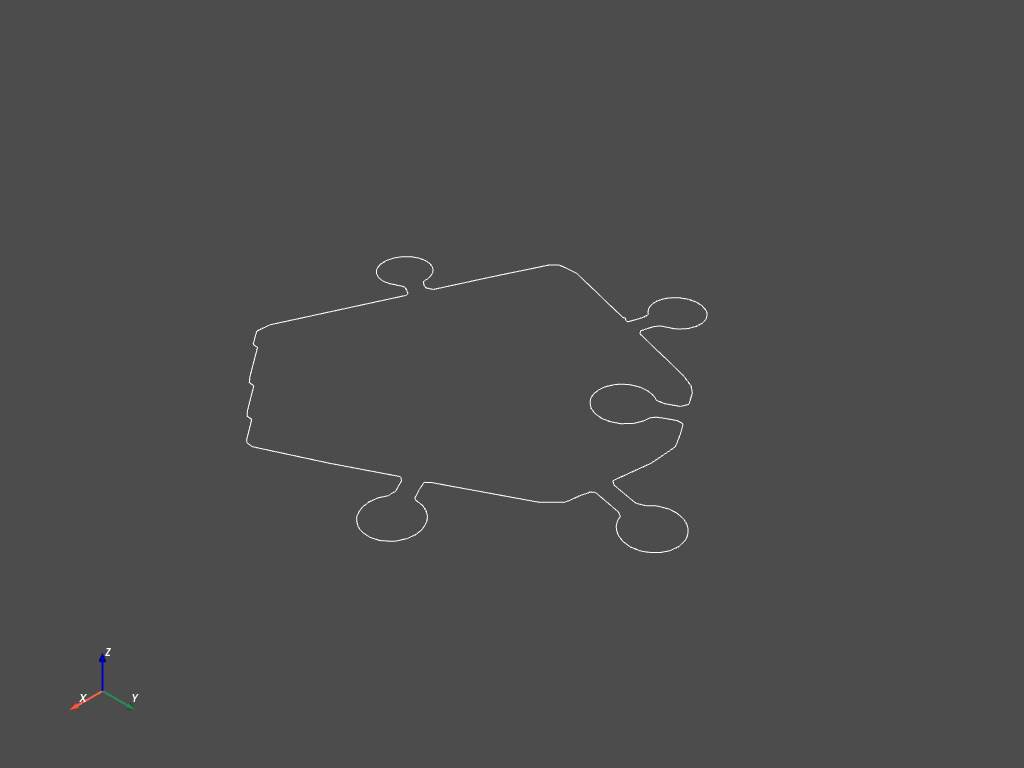

[(74.16529916938005, 180.93612741645035, 24.80878996070085),
 (35.74851989746094, 142.51934814453125, -13.607989311218262),
 (0.0, 0.0, 1.0)]

In [235]:
vmc.project_points_to_plane().extract_feature_edges().plot()

In [209]:
vmc.center

[35.74851989746094, 142.51934814453125, 4.093625545501709]

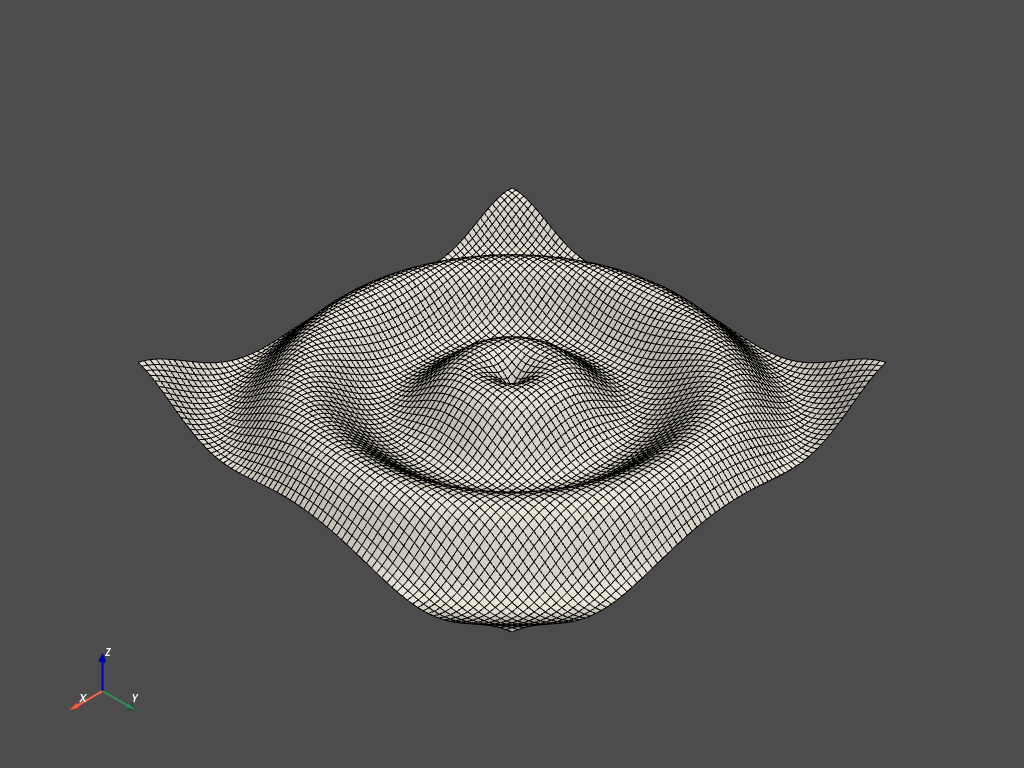

pyvista.core.pointset.StructuredGrid

In [205]:
from pyvista import examples

struct = examples.load_structured()
struct.plot(show_edges=True)
type(struct)

In [206]:
import vtk
extrude = vtk.vtkLinearExtrusionFilter()
extrude.SetInputData(vmc)
extrude.SetExtrusionTypeToVectorExtrusion()

extrude.SetVector(0, 0, 0)

extrude.Update()
extruded_mesh = pyvista.wrap(extrude.GetOutput())
extruded_mesh.elevation().plot(notebook=False)

[(75.23569159799499, 182.0065198450653, 43.58079724603576),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (0.0, 0.0, 1.0)]

In [116]:
dir(vmc)

['ALL_PIECES_EXTENT',
 'AddCellReference',
 'AddObserver',
 'AddReferenceToCell',
 'Allocate',
 'AllocateCellGhostArray',
 'AllocateCopy',
 'AllocateEstimate',
 'AllocateExact',
 'AllocatePointGhostArray',
 'AllocateProportional',
 'AttributeTypes',
 'BOUNDING_BOX',
 'BreakOnError',
 'BuildCellLocator',
 'BuildCells',
 'BuildLinks',
 'BuildLocator',
 'BuildPointLocator',
 'CELL',
 'CELL_DATA_FIELD',
 'CELL_DATA_VECTOR',
 'CheckAttributes',
 'ComputeBounds',
 'CopyAttributes',
 'CopyCells',
 'CopyInformationFromPipeline',
 'CopyInformationToPipeline',
 'CopyStructure',
 'Crop',
 'DATA_EXTENT',
 'DATA_EXTENT_TYPE',
 'DATA_NUMBER_OF_GHOST_LEVELS',
 'DATA_NUMBER_OF_PIECES',
 'DATA_OBJECT',
 'DATA_OBJECT_FIELD',
 'DATA_PIECE_NUMBER',
 'DATA_TIME_STEP',
 'DATA_TYPE_NAME',
 'DIRECTION',
 'DataHasBeenGenerated',
 'DebugOff',
 'DebugOn',
 'DeepCopy',
 'DeleteCell',
 'DeleteCells',
 'DeleteLinks',
 'DeletePoint',
 'EDGE',
 'EDGE_DATA_VECTOR',
 'ERR_INCORRECT_FIELD',
 'ERR_NON_MANIFOLD_STAR',
 'E

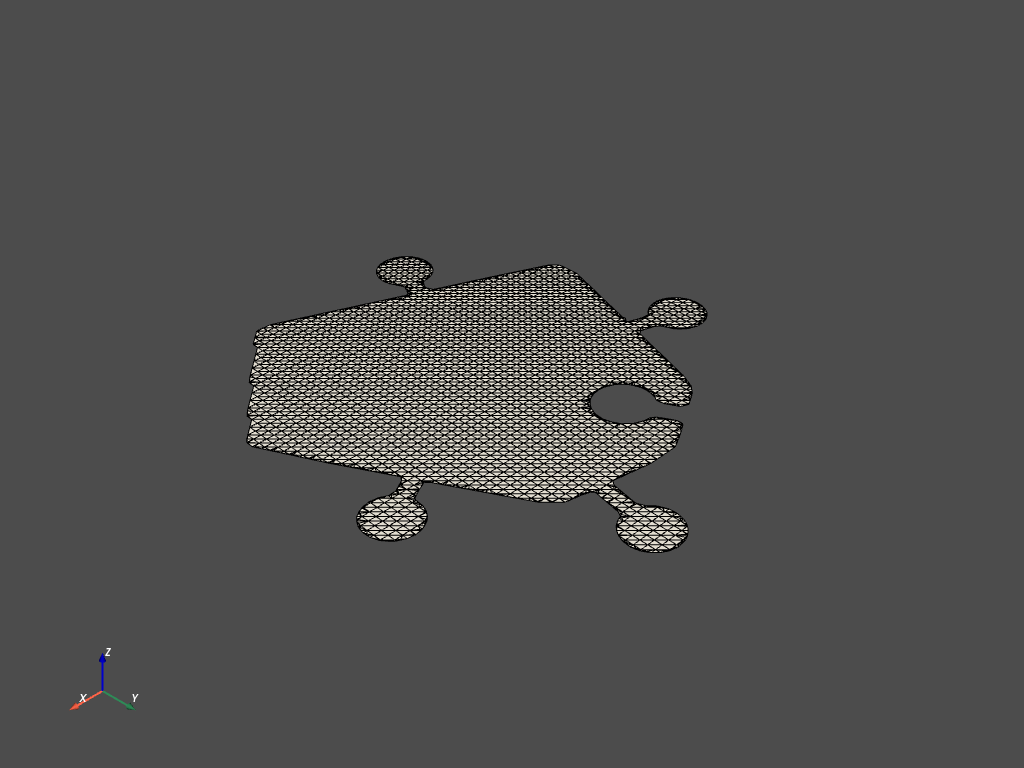

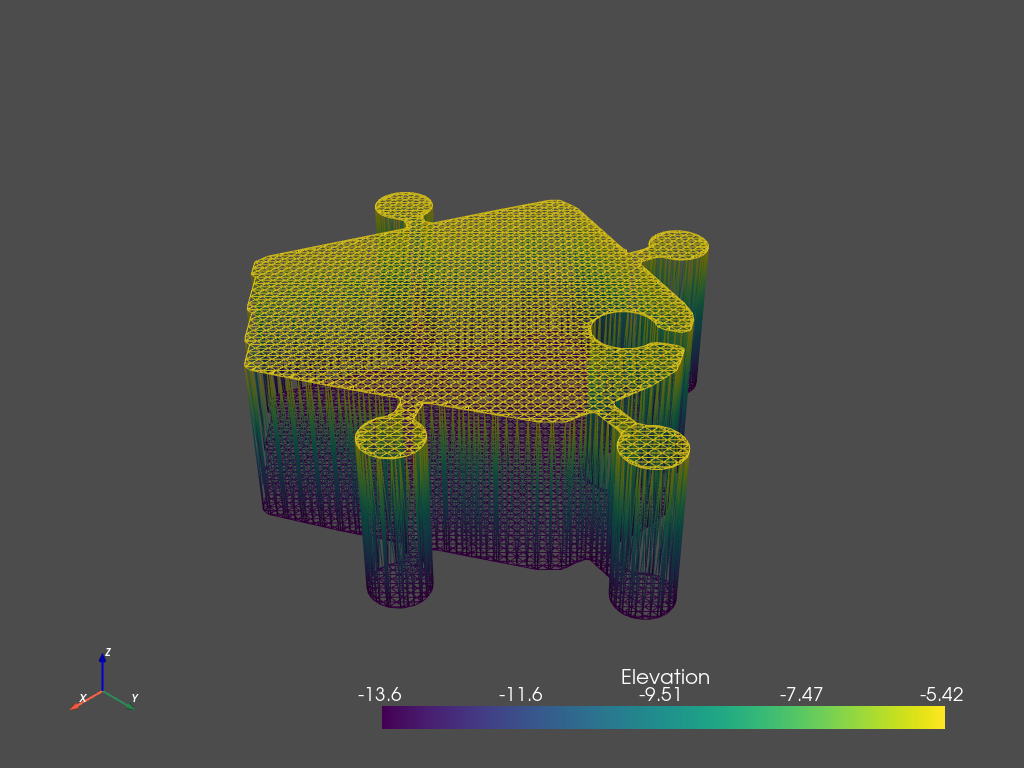

[(75.23569159799499, 182.0065198450653, 29.972807934817496),
 (35.74851989746094, 142.51934814453125, -9.514363765716553),
 (0.0, 0.0, 1.0)]

In [142]:
flat_vmc = vmc.project_points_to_plane()
flat_vmc.plot(show_edges=True)

extrude = vtk.vtkLinearExtrusionFilter()
extrude.SetInputData(flat_vmc)
extrude.SetExtrusionTypeToNormalExtrusion()

extrude.SetVector(0, 0, vmc.bounds[5])

extrude.Update()
extruded_mesh = pyvista.wrap(extrude.GetOutput())
extruded_mesh.elevation().plot(notebook=True, style='wireframe')

In [50]:
vmc.save('tmp.stl')

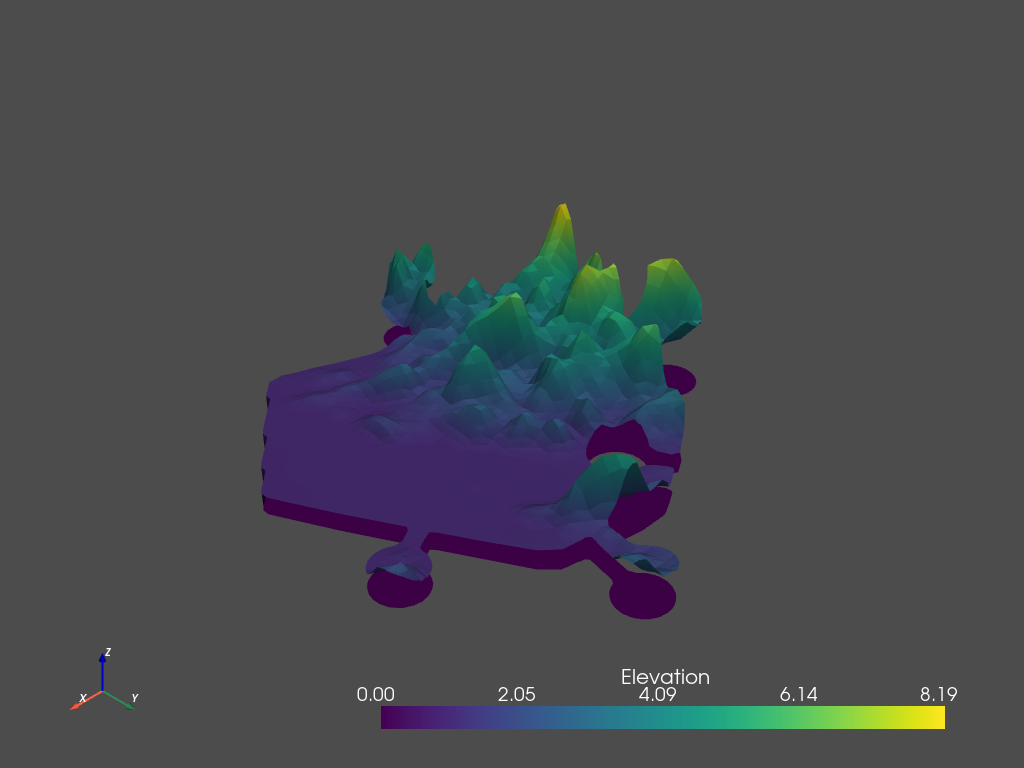

[(75.23569159799499, 182.0065198450653, 43.58079724603576),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (0.0, 0.0, 1.0)]

In [44]:
vmc.elevation().plot()

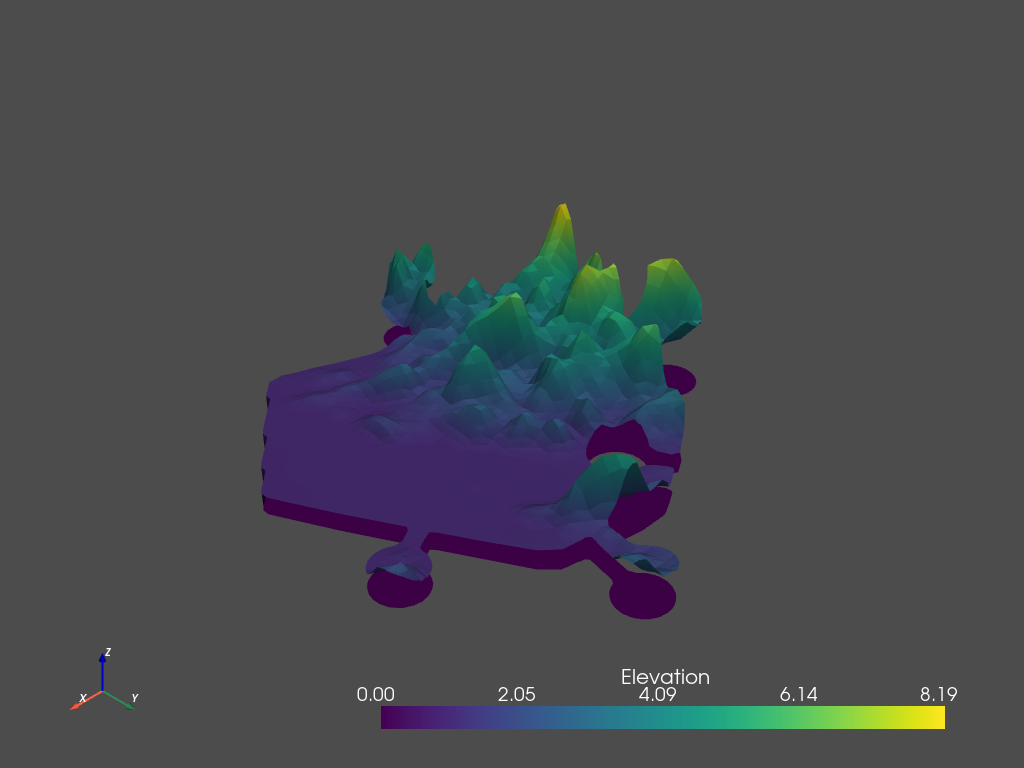

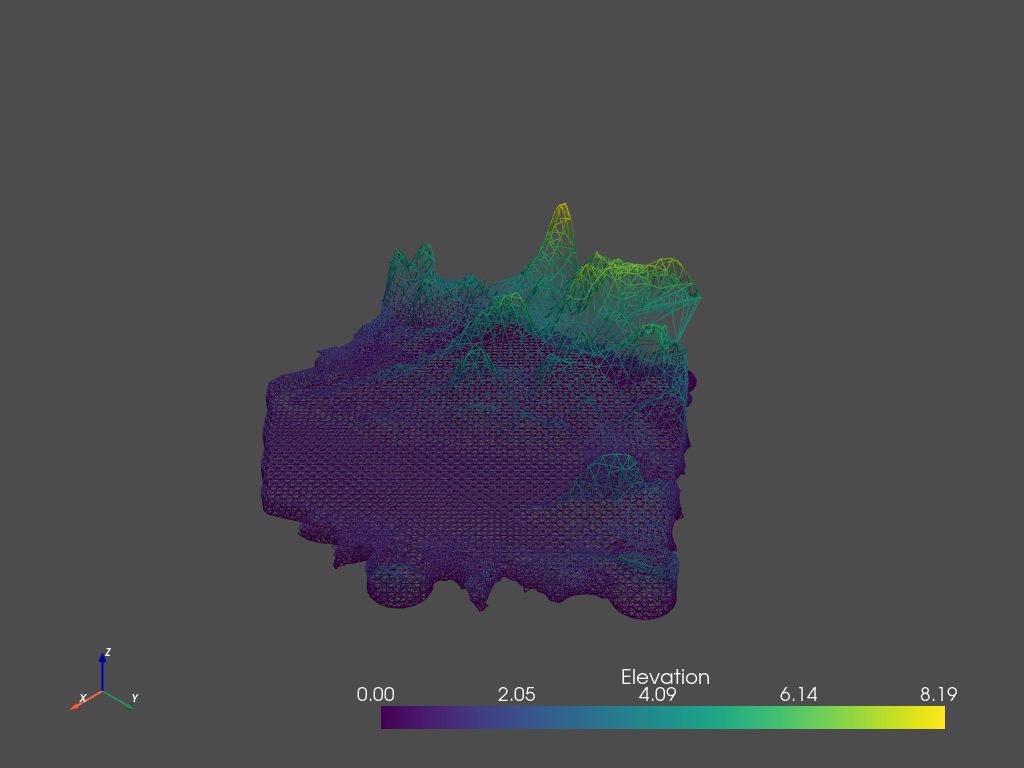

[(75.23569159799499, 182.0065198450653, 43.58079724603576),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (0.0, 0.0, 1.0)]

In [161]:
vmc.triangulate().elevation().plot()

fixer = pymeshfix.MeshFix(vmc.triangulate())
fixer.repair()
fixer.mesh.elevation().plot(style='wireframe')




* take boundary
* find points that hit that
* connect mesh

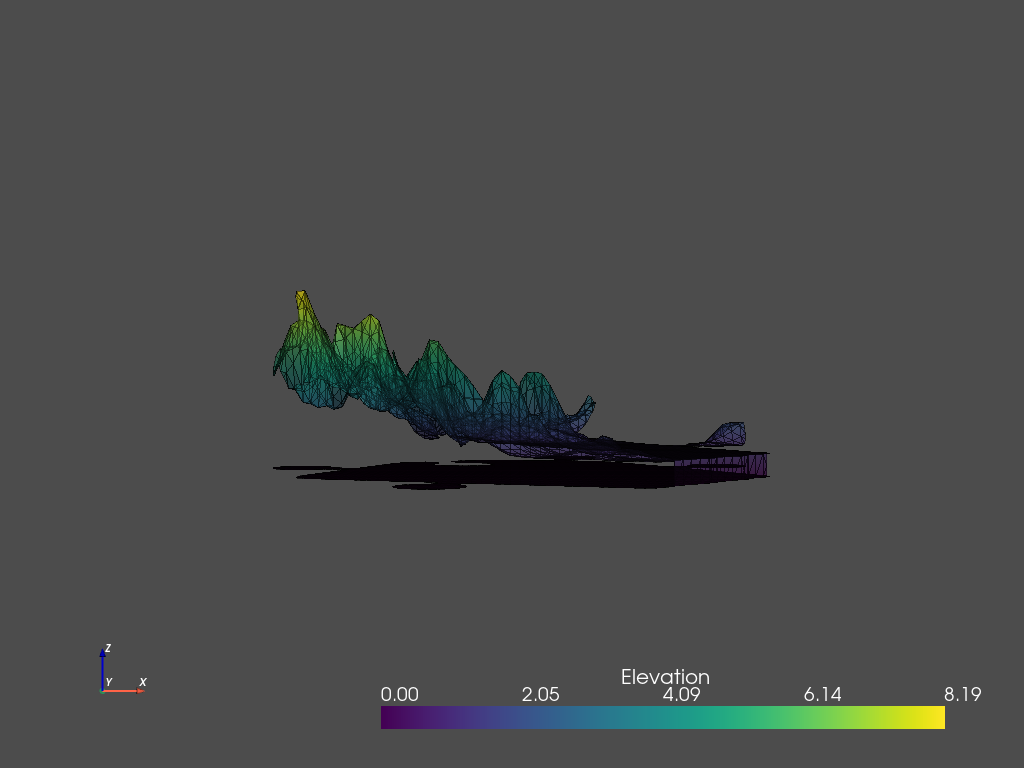

[(35.74851989746094, 74.12556051201034, 4.093625545501709),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (0.0, 0.0, 1.0)]

In [154]:
vmc.fill_holes(1).elevation().plot(show_edges=True, opacity=0.7,cpos='xz')

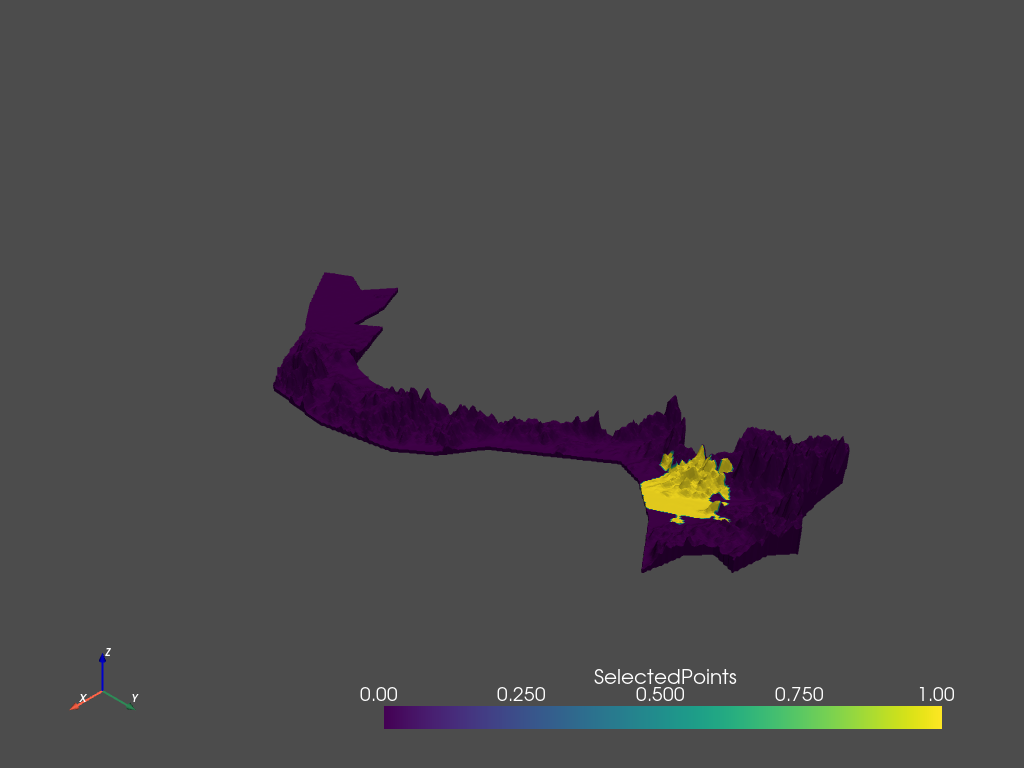

[(251.67317482796756, 297.4167661365613, 218.90099093285647),
 (40.0, 85.74359130859375, 7.227816104888916),
 (0.0, 0.0, 1.0)]

In [144]:
viet_mesh.select_enclosed_points(m).plot(notebook=True)

In [13]:
import tetgen
tet = tetgen.TetGen(viet_mesh)
tet.make_manifold()
tet.tetrahedralize()

e_c = tet.grid.select_enclosed_points(m).threshold(0.9)

/Users/nickvazz/Code/Puzzle3D/venv/lib/python3.8/site-packages/tetgen/pytetgen.py:534: UserWarning: VTK 9 no longer accepts an offset array
  self._grid = pv.UnstructuredGrid(offset, cells, cell_type, self.node)


In [14]:
tgcm = tet.grid.clip_surface(m)

In [15]:
vmcsm = viet_mesh.clip_surface(m)

In [16]:
type(vmcsm), dir(vmcsm)

(pyvista.core.pointset.PolyData,
 ['ALL_PIECES_EXTENT',
  'AddCellReference',
  'AddObserver',
  'AddReferenceToCell',
  'Allocate',
  'AllocateCellGhostArray',
  'AllocateCopy',
  'AllocateEstimate',
  'AllocateExact',
  'AllocatePointGhostArray',
  'AllocateProportional',
  'AttributeTypes',
  'BOUNDING_BOX',
  'BreakOnError',
  'BuildCellLocator',
  'BuildCells',
  'BuildLinks',
  'BuildLocator',
  'BuildPointLocator',
  'CELL',
  'CELL_DATA_FIELD',
  'CELL_DATA_VECTOR',
  'CheckAttributes',
  'ComputeBounds',
  'CopyAttributes',
  'CopyCells',
  'CopyInformationFromPipeline',
  'CopyInformationToPipeline',
  'CopyStructure',
  'Crop',
  'DATA_EXTENT',
  'DATA_EXTENT_TYPE',
  'DATA_NUMBER_OF_GHOST_LEVELS',
  'DATA_NUMBER_OF_PIECES',
  'DATA_OBJECT',
  'DATA_OBJECT_FIELD',
  'DATA_PIECE_NUMBER',
  'DATA_TIME_STEP',
  'DATA_TYPE_NAME',
  'DIRECTION',
  'DataHasBeenGenerated',
  'DebugOff',
  'DebugOn',
  'DeepCopy',
  'DeleteCell',
  'DeleteCells',
  'DeleteLinks',
  'DeletePoint',
  

In [19]:
import pymeshfix

meshfix = pymeshfix.MeshFix(vmcsm)
meshfix.repair(joincomp=True)

meshfix.mesh.plot(notebook=False, style='wireframe', opacity=0.5)

[(19.155824619192135, 132.33835951103822, 69.65840359415715),
 (35.74851989746094, 142.51934814453125, 4.093625545501709),
 (-0.4763564674022504, -0.8425496488732888, -0.25138537178512765)]

In [21]:
>>> import pyvista
>>> import numpy as np
>>> cylinder = pyvista.Cylinder(np.array([1, 2, 3]), np.array([1, 1, 1]), 1, 1)
>>> cylinder.plot(notebook=False) 

[(-2.350717062615584, -4.591541003248255, 3.112215713167378),
 (1.0, 2.0, 3.0000001192092896),
 (0.18701516725121592, -0.11168192366905083, -0.975987948257344)]

In [18]:
break

SyntaxError: 'break' outside loop (<ipython-input-18-6aaf1f276005>, line 1)

In [ ]:
e_c.plot(show_edges=True, style='wireframe', notebook=False)


In [ ]:
e_p.plot(notebook=False, show_edges=True, style='wireframe')

In [ ]:
len(tet.grid.points)

In [ ]:
m_clip.elevation().plot(notebook=False)

In [ ]:
surface = examples.load_random_hills()

# Create a grid around that surface
grid = pv.create_grid(surface)

# Clip the grid using the surface
model = grid.clip_surface(surface)

# Compute height and display it
model.elevation().plot(notebook=False)

In [ ]:
import trimesh
m = trimesh.load('./viet/V2_2_105.75_15.98_tile_1_1.stl')
print(m.is_watertight)
# m.show()

In [ ]:
import trimesh
points = [[0, 0, 0], [0, 0, 1], [0, 1, 0]]
faces = [[0, 1, 2]]
tmesh = trimesh.Trimesh(points, faces=faces, process=False)
mesh = pv.wrap(tmesh)
print(mesh)
print(type(tmesh))

print(type(tc.triangulate_polygon(pieces[0])))

In [ ]:
import trimesh


mesh_verts_faces = [tc.triangulate_polygon(p) for p in pieces]
mesh_verts = []
mesh_faces = []
for idx, (v, f) in enumerate(mesh_verts_faces):
    v0 = np.zeros((v.shape[0]*2,3))
    v0[:,:2] = np.vstack([v,v])
    v0[:len(v),2] = viet_bounds[4] - 1
    v0[len(v):,2] = viet_bounds[5] + 1
    
    f0 = np.vstack([f,f])
    f0[len(v):] += len(v)
    
    side_f = []
    for i in range(0,len(v),2):
        side_f.append([i,i+1,len(v)+i-1])
        side_f.append([i+1,len(v)+i-1,len(v)+i])
    
    f0 = np.vstack([f0, side_f])
        
    mesh_verts.append(v0)
    mesh_faces.append(f0)

trimeshes = [
    trimesh.Trimesh(vertices=v, faces=f, process=False) 
    for v, f in zip(mesh_verts, mesh_faces)
]
[
    [
        trimesh.repair.fill_holes(t),
        trimesh.repair.fix_normals(t),
        trimesh.repair.fix_winding(t),
    ]
    for t in trimeshes
]
print([t.is_watertight for t in trimeshes])

p = pv.Plotter(notebook=False)
for tm in trimeshes:
    p.add_mesh(pv.wrap(tm), show_edges=True, opacity=0.6)
p.show()



print(trimeshes[0].bounds)
print(trimeshes[1].bounds)
print('2')

In [ ]:
v, m = mesh_verts_faces[0]

v = np.hstack((v,v))[:,:3]
v[:,2] = 0
v

pv.wrap(
    trimesh.Trimesh(vertices=v, faces=f, process=False)
).plot(show_edges=True, notebook=False)

In [ ]:
plt.scatter(v0[:,0], v0[:,1], c=list(range(len(v0))))
plt.plot(v0[:,0], v0[:,1])
plt.show()

In [ ]:
help(trimesh.util.submesh) # submesh

In [ ]:
mesh_piece = mesh_pieces[0]
piece = np.vstack(pieces[0].exterior.xy).T
np.where(mesh_piece[0][0,:2] == piece), np.where(mesh_piece[0][1,:2] == piece)
# surf = pv.PolyData(vertices, faces)


In [ ]:
p = pv.Plotter()
for piece in pieces_3d:
    p.add_mesh(piece, opacity=0.5, show_edges=True)
p.add_mesh(viet_mesh)
p.show()

In [ ]:
viet_mesh.clip_surface(piece, invert=False).plot()

In [ ]:
block = pv.MultiBlock()
block.append(pieces_3d[0])
block = block.combine(True).extract_surface().clean(tolerance=0.1)
block.plot()
block.delaunay_2d(bound=True).plot()

In [ ]:
viet_mesh_pieces = [
    viet_mesh.select_enclosed_points(p, check_surface=False).threshold(0.01)
    for p in pieces_3d
]

In [ ]:
# p = pv.Plotter()
for idx, piece in enumerate(viet_mesh_pieces):
#     p.add_mesh(piece, opacity=0.5, show_edges=False)
    path = f"./Pieces/viet_piece_{idx+1:03}_{n_pieces:03}.stl"
#     piece.save(path)
# p.add_mesh(viet_mesh)
# p.show()

In [ ]:
piece.delaunay_3d(alpha=1).plot(notebook=True)

In [ ]:
piece.delaunay_2d(bound=True).plot(notebook=True)

In [ ]:
edges = piece.extract_feature_edges(boundary_edges=True,
                           feature_edges=True,
                           manifold_edges=True)

p = pv.Plotter(notebook=True)
p.add_mesh(piece, color=True)
p.add_mesh(edges, color="red", line_width=5)
p.show()

In [ ]:
edges = viet_mesh.delaunay_2d().extract_feature_edges(boundary_edges=True,
                           feature_edges=True,
                           manifold_edges=True)

p = pv.Plotter(notebook=True)
p.add_mesh(viet_mesh, color=True)
p.add_mesh(edges, color="red", line_width=5)
p.show()